In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error
paleta_colores = sns.color_palette()
plt.style.use("fivethirtyeight")


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

# Selección del set de datos y la elección de las columnas a emplear

In [2]:
dataframe = pd.read_excel(r'C:\Users\harol\Downloads\dataverse_files\Dengue_selected_cities.xlsx', sheet_name = "Maranguape", usecols = ["date", "N_cases", "temp", "wind", "percipitation", "humidity"])
dataframe

,date,N_cases,temp,wind,percipitation,humidity
0,2010-01-03,0,300.355608,5.819300,15.016184,0.016344
1,2010-01-10,0,300.540331,5.953620,8.522304,0.015986
2,2010-01-17,1,300.997838,5.603297,6.676003,0.016221
3,2010-01-24,0,301.061384,6.102912,14.994275,0.016666
4,2010-01-31,1,301.526215,7.320112,13.449473,0.017355
...,...,...,...,...,...,...
339,2016-07-03,10,299.925598,7.064259,9.669062,0.015421
340,2016-07-10,10,300.311929,6.866001,2.152800,0.014416
341,2016-07-17,2,300.262796,6.193589,1.913044,0.014006
342,2016-07-24,3,300.224832,7.158983,3.300317,0.012785


# Selección de las fechas a ser empleada

In [3]:
dataframe = dataframe.set_index("date")
dataframe = dataframe.loc[ dataframe.index > "2011-01-01"]
dataframe

,N_cases,temp,wind,percipitation,humidity
date,,,,,
2011-01-02,0,300.087677,5.840723,20.280739,0.016522
2011-01-09,4,299.088645,5.468983,20.683040,0.016921
2011-01-16,3,298.302939,4.656257,31.150970,0.017345
2011-01-23,4,298.255820,4.677987,26.265675,0.017456
2011-01-30,7,298.869564,5.165177,18.017809,0.017857
...,...,...,...,...,...
2016-07-03,10,299.925598,7.064259,9.669062,0.015421
2016-07-10,10,300.311929,6.866001,2.152800,0.014416
2016-07-17,2,300.262796,6.193589,1.913044,0.014006


# Gráfico de número de casos de dengue por semana

<AxesSubplot: title={'center': 'Casos de dengue semanales'}, xlabel='date'>

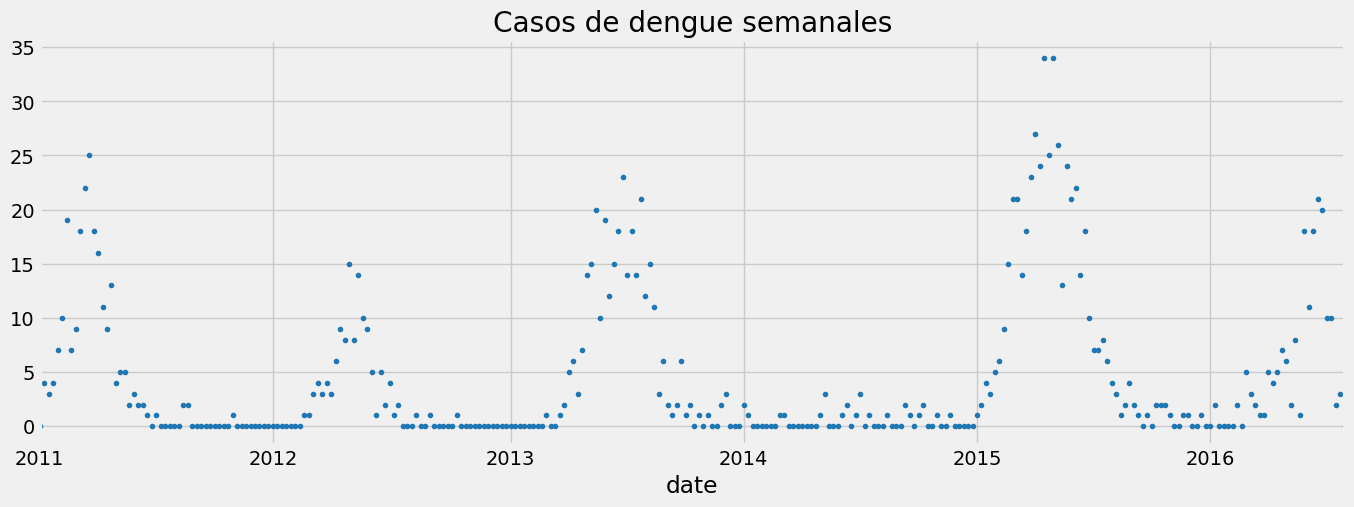

In [4]:
dataframe["N_cases"].plot(style=".", figsize=(15, 5), color=paleta_colores[0], title="Casos de dengue semanales")

# Creación de características

In [5]:
def crear_caracteristicas(dataframe):
    dataframe["week"] = dataframe.index.isocalendar().week
    dataframe["week"] = dataframe["week"].astype(np.int64)
    return dataframe
dataframe = crear_caracteristicas(dataframe)

# Visualizar características

Text(0.5, 1.0, 'Numero_casos por semana')

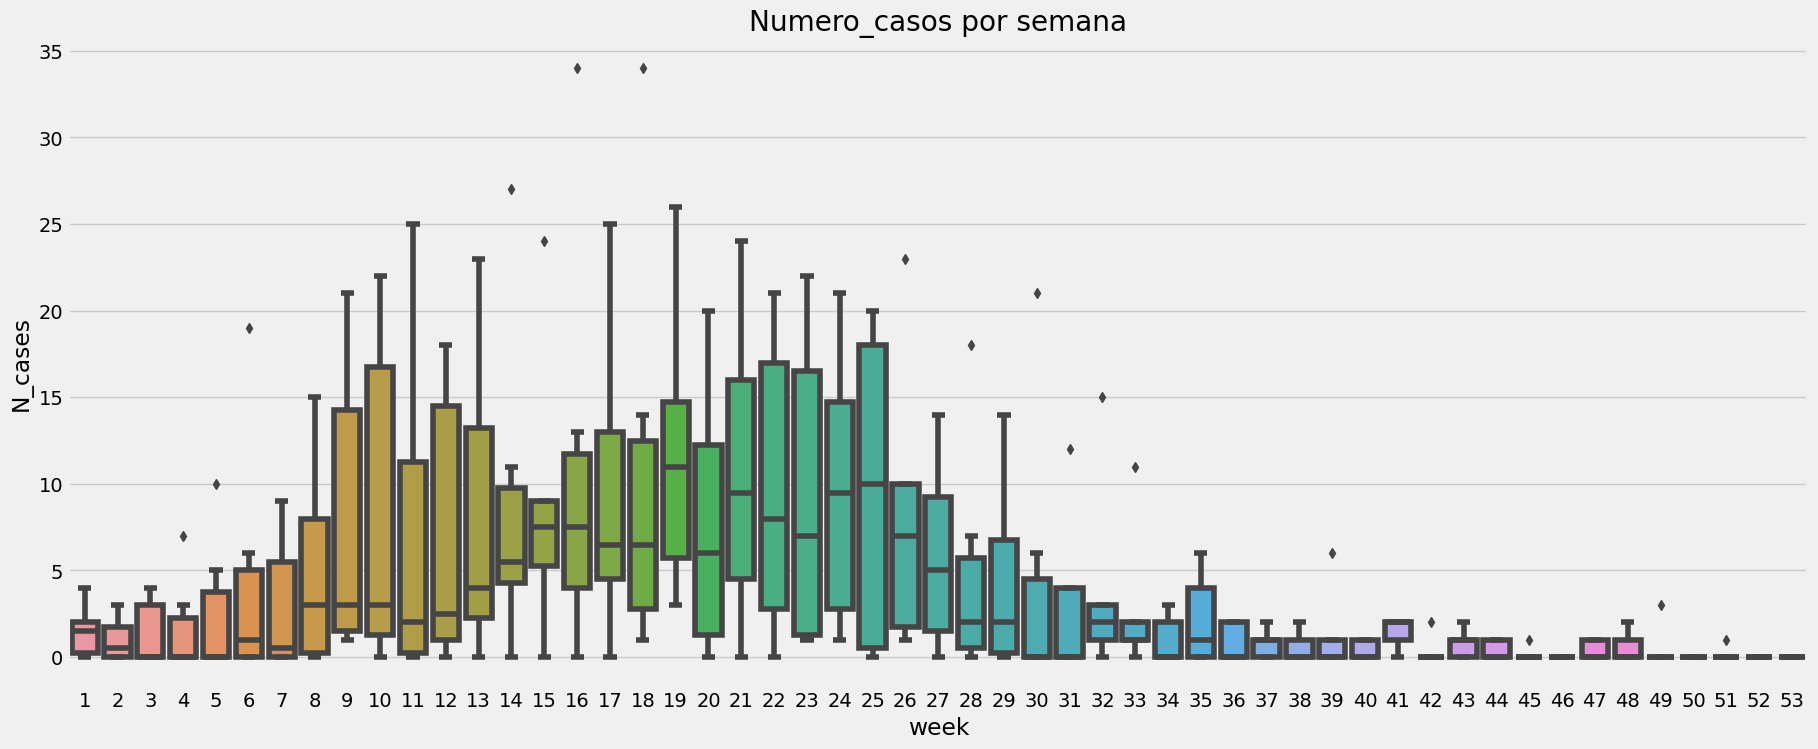

In [6]:
fig, ax = plt.subplots(figsize = (20, 8))
sns.boxplot( data = dataframe, x="week", y="N_cases" )
ax.set_title( "Numero_casos por semana" )

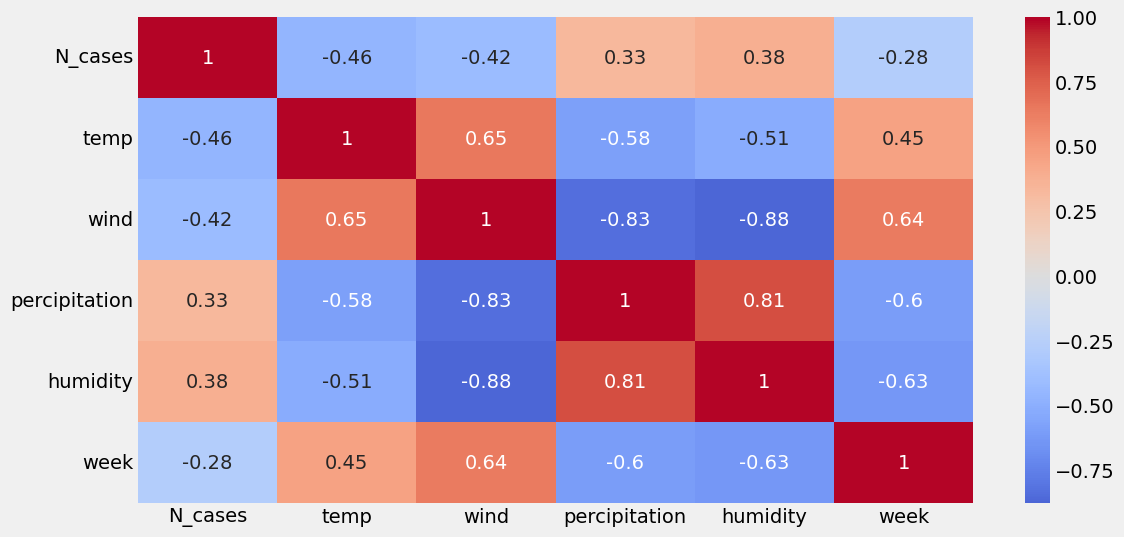

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.heatmap(dataframe.corr(), cmap='coolwarm', annot=True, center=0)
plt.show()

# Crear el modelo

### Selección de las etiquetas (características) y el objetivo

### Partir aleatoriamente la data

In [8]:
from sklearn.model_selection import train_test_split
X, y = dataframe[["week", "temp", "wind", "percipitation", "humidity"]].values, dataframe['N_cases'].values
df_train, df_test = train_test_split(dataframe, test_size=14, shuffle=False)
X_train, y_train = df_train[["week", "temp", "wind", "percipitation", "humidity"]].values, df_train['N_cases'].values.T
        
X_test, y_test = df_test[["week", "temp", "wind", "percipitation", "humidity"]].values, df_test['N_cases'].values.T

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 278 rows
Test Set: 14 rows


### Creación del modelo empleando el algoritmo XGBoost

In [9]:
coeficiente_aprendizaje = [0.1, 0.05, 0.01, 0.005, 0.0001]
numero_estimaciones = [10, 100, 1000, 10000, 100000]
data_train = []
data_test = []

for i in range(len(coeficiente_aprendizaje)):
    for j in range(len(numero_estimaciones)):
        a = coeficiente_aprendizaje[i]
        b = numero_estimaciones[j]
        
        model = xgb.XGBRegressor(n_estimators=b, max_depth=7, learning_rate=a, early_stopping_rounds=10, num_parallel_tree=4)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
        
        rmse_train = mean_squared_error(y_train, model.predict(X_train), squared=False)
        rmse_test = mean_squared_error(y_test, model.predict(X_test), squared=False)
        
        data_train.append([a, b, rmse_train])
        data_test.append([a, b, rmse_test])
        
df_train = pd.DataFrame(data_train, columns=['CoeficienteAprendizaje', 'NumeroEstimadores', 'RMSE_Train'])
df_test = pd.DataFrame(data_test, columns=['CoeficienteAprendizaje', 'NumeroEstimadores', 'RMSE_Test'])

[0]	validation_0-rmse:7.42233	validation_1-rmse:11.16413
[9]	validation_0-rmse:4.30755	validation_1-rmse:9.92697
[0]	validation_0-rmse:7.42233	validation_1-rmse:11.16413
[84]	validation_0-rmse:0.38178	validation_1-rmse:9.40284
[0]	validation_0-rmse:7.42233	validation_1-rmse:11.16413
[84]	validation_0-rmse:0.38178	validation_1-rmse:9.40284
[0]	validation_0-rmse:7.42233	validation_1-rmse:11.16413
[85]	validation_0-rmse:0.37635	validation_1-rmse:9.40509
[0]	validation_0-rmse:7.42233	validation_1-rmse:11.16413
[85]	validation_0-rmse:0.37635	validation_1-rmse:9.40509
[0]	validation_0-rmse:7.66625	validation_1-rmse:11.25166
[9]	validation_0-rmse:5.87385	validation_1-rmse:10.62539
[0]	validation_0-rmse:7.66625	validation_1-rmse:11.25166
[57]	validation_0-rmse:1.71526	validation_1-rmse:9.23925
[0]	validation_0-rmse:7.66625	validation_1-rmse:11.25166
[56]	validation_0-rmse:1.75517	validation_1-rmse:9.26175
[0]	validation_0-rmse:7.66625	validation_1-rmse:11.25166
[57]	validation_0-rmse:1.71526	v

[10300]	validation_0-rmse:4.35476	validation_1-rmse:9.74828
[10400]	validation_0-rmse:4.33219	validation_1-rmse:9.74595
[10500]	validation_0-rmse:4.30983	validation_1-rmse:9.74372
[10600]	validation_0-rmse:4.28764	validation_1-rmse:9.74143
[10700]	validation_0-rmse:4.26549	validation_1-rmse:9.73864
[10800]	validation_0-rmse:4.24268	validation_1-rmse:9.73425
[10900]	validation_0-rmse:4.22043	validation_1-rmse:9.73081
[11000]	validation_0-rmse:4.19884	validation_1-rmse:9.72816
[11100]	validation_0-rmse:4.17739	validation_1-rmse:9.72464
[11200]	validation_0-rmse:4.15601	validation_1-rmse:9.72101
[11300]	validation_0-rmse:4.13482	validation_1-rmse:9.71748
[11400]	validation_0-rmse:4.11380	validation_1-rmse:9.71403
[11500]	validation_0-rmse:4.09296	validation_1-rmse:9.71067
[11600]	validation_0-rmse:4.07226	validation_1-rmse:9.70733
[11700]	validation_0-rmse:4.05214	validation_1-rmse:9.70390
[11800]	validation_0-rmse:4.03239	validation_1-rmse:9.70063
[11900]	validation_0-rmse:4.01315	valida

In [10]:
df_train

,CoeficienteAprendizaje,NumeroEstimadores,RMSE_Train
0,0.1000,10,4.307547
1,0.1000,100,0.438328
2,0.1000,1000,0.438328
3,0.1000,10000,0.438328
4,0.1000,100000,0.438328
5,0.0500,10,5.873850
6,0.0500,100,2.172533
7,0.0500,1000,2.172533
8,0.0500,10000,2.172533
9,0.0500,100000,2.172533


In [11]:
df_test

,CoeficienteAprendizaje,NumeroEstimadores,RMSE_Test
0,0.1000,10,9.926970
1,0.1000,100,9.380412
2,0.1000,1000,9.380412
3,0.1000,10000,9.380412
4,0.1000,100000,9.380412
5,0.0500,10,10.625387
6,0.0500,100,9.224757
7,0.0500,1000,9.224757
8,0.0500,10000,9.224757
9,0.0500,100000,9.224757


In [12]:
model = xgb.XGBRegressor(n_estimators=10000, max_depth=7, learning_rate=0.005, early_stopping_rounds=10, num_parallel_tree=4)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:7.88906	validation_1-rmse:11.33426
[100]	validation_0-rmse:5.90450	validation_1-rmse:10.54145
[200]	validation_0-rmse:4.40690	validation_1-rmse:9.70784
[300]	validation_0-rmse:3.43418	validation_1-rmse:9.51879
[400]	validation_0-rmse:2.63903	validation_1-rmse:9.30159
[455]	validation_0-rmse:2.29709	validation_1-rmse:9.22527


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.005, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=4, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

Característica: f0:week, Score: 24688.00000
Característica: f1:temp, Score: 31196.00000
Característica: f2:wind, Score: 14920.00000
Característica: f3:percipitation, Score: 17460.00000
Característica: f4:humidity, Score: 14880.00000


<Figure size 1200x800 with 0 Axes>

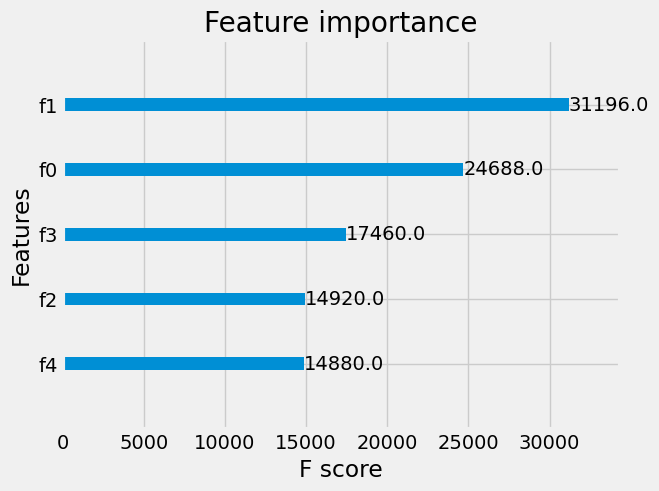

In [13]:
importancias = model.get_booster().get_score(importance_type='weight')
from xgboost import plot_importance
nombre_caracteristicas = ["week", "temp", "wind", "percipitation", "humidity"]
i = 0
for caracteristica, importancia in importancias.items():
    print('Característica: %s, Score: %.5f' % ( caracteristica + ":" + nombre_caracteristicas[i], importancia))
    i = i + 1
plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight', max_num_features=12)
plt.show()

# Pronóstico de predicción

In [77]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

## Predicción en el modelo en data de prueba

In [106]:
predictions = model.predict(X_test)
predictions_test = predictions
def relative_root_mean_squared_error(rmse, y_test):    
    den = np.max(y_test) - np.min(y_test)
    return (rmse/den)

mse = mean_squared_error(y_test, predictions)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions) if r2_score(y_test, predictions) >= 0 else 0.0
print("R2:", r2)

print("R-RMSE:", relative_root_mean_squared_error(rmse, y_test))

print('Correlación de Pearson:', pearsonr(y_test, predictions)[0])

RMSE: 9.223042492461829
R2: 0.0
R-RMSE: 0.43919249964103946
Correlación de Pearson: -0.07614035264757399


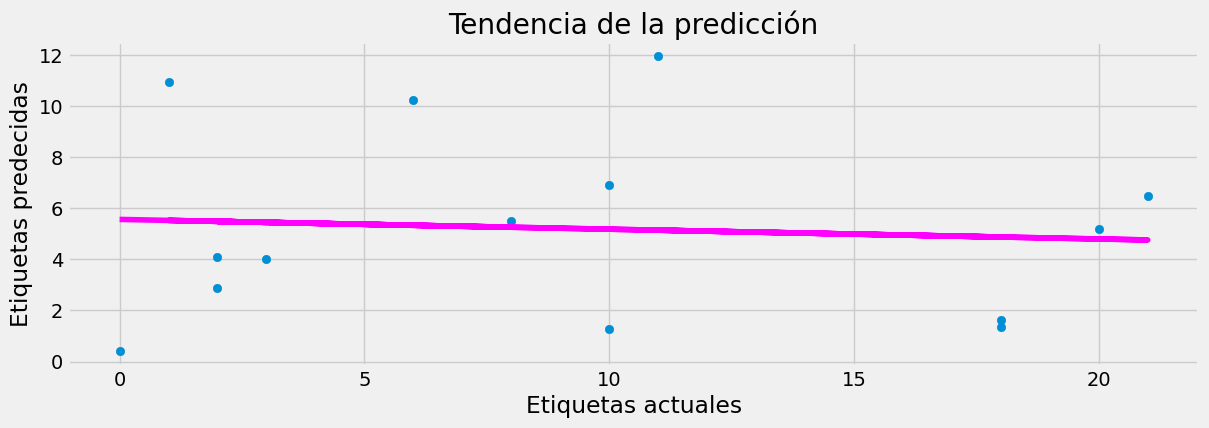

In [107]:
# Plot predicted vs actual
plt.figure(figsize=(13, 4))
plt.scatter(y_test, predictions)
plt.xlabel('Etiquetas actuales')
plt.ylabel('Etiquetas predecidas')
plt.title('Tendencia de la predicción')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

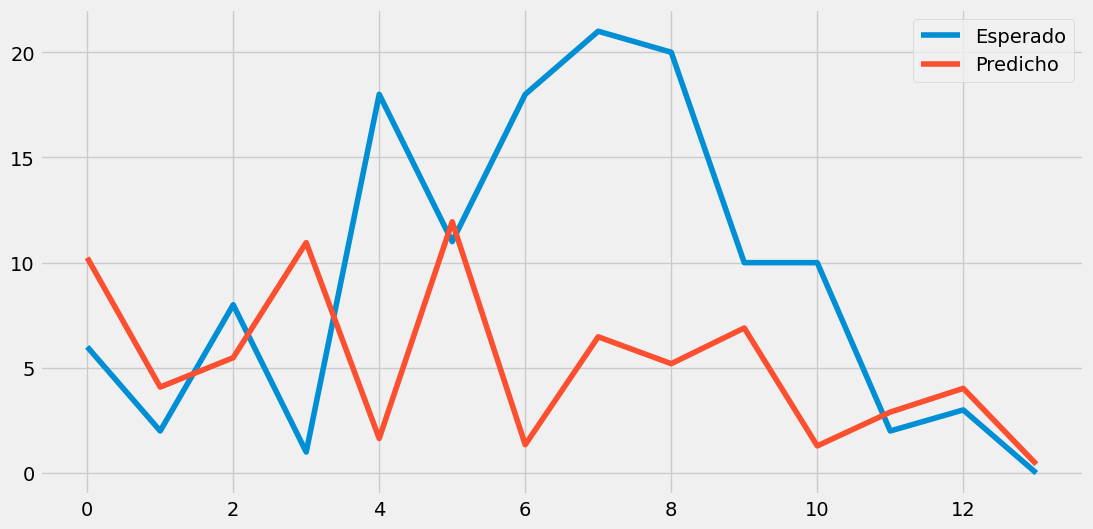

array([ 6,  2,  8,  1, 18, 11, 18, 21, 20, 10, 10,  2,  3,  0],
      dtype=int64)

In [80]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(y_test, label='Esperado')
plt.plot(predictions, label='Predicho')
plt.legend()
plt.show()
y_test

## Predicción en el modelo en data de entrenamiento

In [105]:
predictions = model.predict(X_train)

# Display metrics
mse = mean_squared_error(y_train, predictions)

rmse = np.sqrt(mse)

print("RMSE:", rmse)

r2 = r2_score(y_train, predictions) if r2_score(y_train, predictions) >= 0 else 0.0
print("R2:", r2)

print("R-RMSE:", relative_root_mean_squared_error(rmse, y_train))

print('Correlación de Pearson:', pearsonr(y_train, predictions)[0])

RMSE: 2.3420919040716495
R2: 0.8855484516660521
R-RMSE: 0.06888505600210734
Correlación de Pearson: 0.9774017288181522


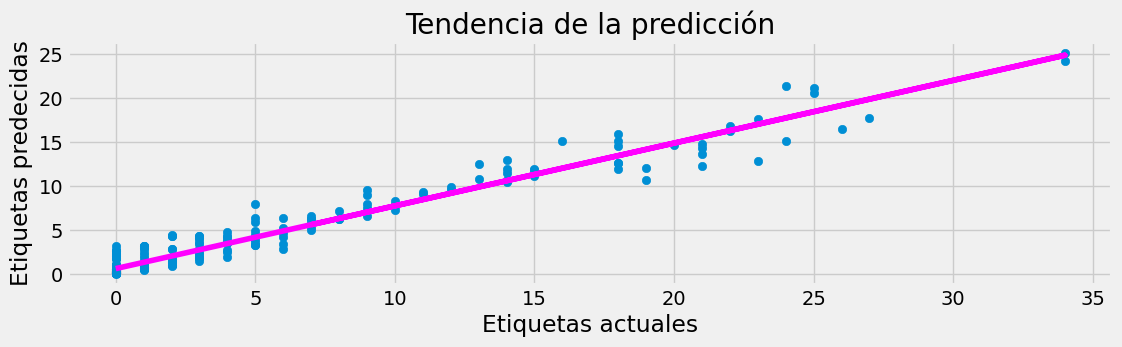

In [82]:
# Plot predicted vs actual
plt.figure(figsize=(12, 3))
plt.scatter(y_train, predictions)
plt.xlabel('Etiquetas actuales')
plt.ylabel('Etiquetas predecidas')
plt.title('Tendencia de la predicción')
# overlay the regression line
z = np.polyfit(y_train, predictions, 1)
p = np.poly1d(z)
plt.plot(y_train,p(y_train), color='magenta')
plt.show()

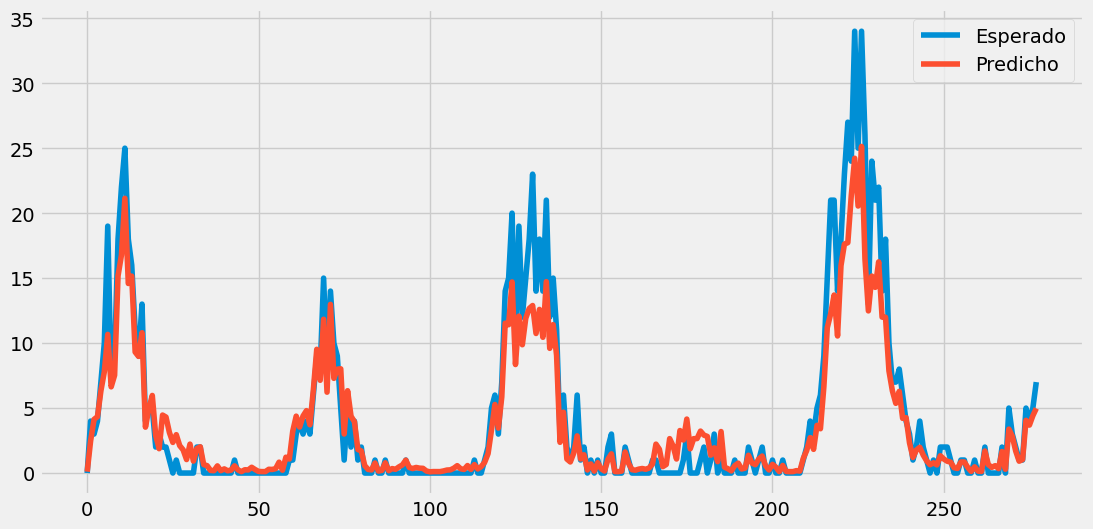

In [83]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(y_train, label='Esperado')
plt.plot(predictions, label='Predicho')
plt.legend()
plt.show()

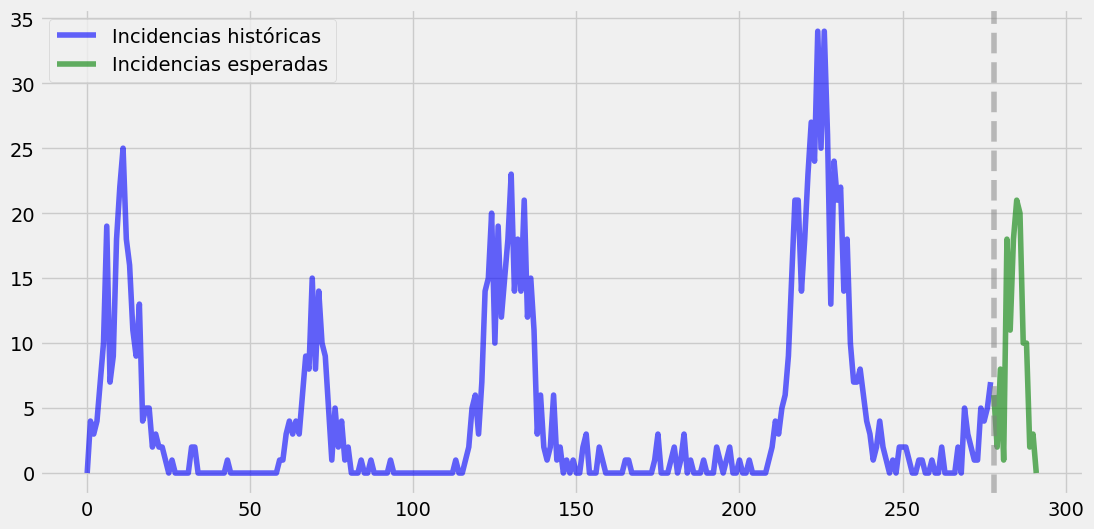

In [91]:
esperado = np.concatenate((y_train, y_test))

fig, ax = plt.subplots(figsize=(12, 6))

# Dibujar y_train
plt.plot(y_train, label='Incidencias históricas', color='blue', alpha=0.6)

# Dibujar y_test
plt.plot(range(len(y_train), len(esperado)), y_test, label='Incidencias esperadas', color='green', alpha=0.6)

# Dibujar la línea donde empieza y_test y predictions
plt.axvline(x=len(y_train), color='grey', linestyle='--', alpha = 0.5)

plt.legend()
plt.show()

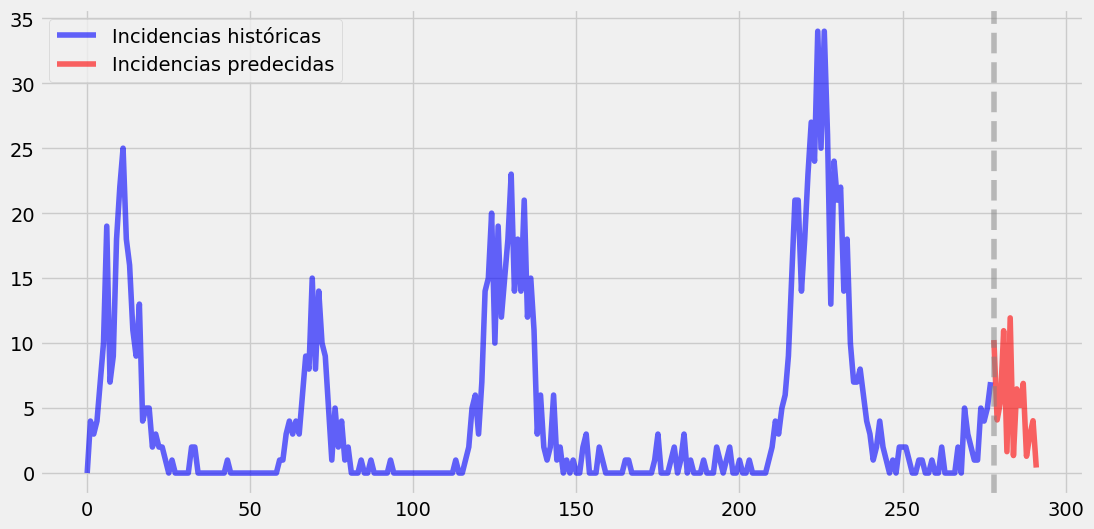

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))

# Dibujar y_train
plt.plot(y_train, label='Incidencias históricas', color='blue', alpha=0.6)

# Dibujar y_test
plt.plot(range(len(y_train), len(esperado)), predictions_test, label='Incidencias predecidas', color='red', alpha=0.6)

# Dibujar la línea donde empieza y_test y predictions
plt.axvline(x=len(y_train), color='grey', linestyle='--', alpha = 0.5)

plt.legend()
plt.show()